<a href="https://colab.research.google.com/github/olfabre/amsProjetSemestre2/blob/main/05_03_LSTM_AvecATTENTION_CourbePerte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-17-bccfcc3a11c7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder = torch.load("models/password_lstm_attention.pt").to(device)


✅ Modèle chargé avec succès !

📊 Résultats de la validation sur 500 échantillons :
   - Validation Loss : 3.3505
   - Validation Accuracy : 17.78%


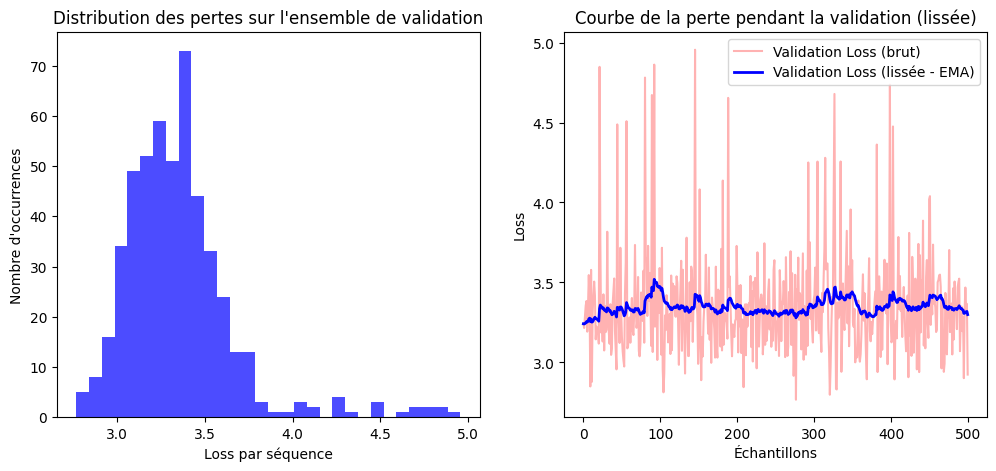

In [17]:
import numpy as np

# Charger le modèle entraîné
if path.exists("models/password_lstm_attention.pt"):
    decoder = torch.load("models/password_lstm_attention.pt").to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode(open("sample_data/validation2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier validation2.txt est introuvable.")
    exit()

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Fonction pour appliquer une moyenne mobile exponentielle (EMA)
def exponential_moving_average(values, alpha=0.01):
    ema = []
    avg = values[0]  # Initialisation avec la première valeur
    for value in values:
        avg = alpha * value + (1 - alpha) * avg  # Mise à jour EMA
        ema.append(avg)
    return ema

# Fonction d'évaluation avec suivi des pertes
def evaluate_model(num_samples=500):
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []

    with torch.no_grad():  # Désactiver le calcul des gradients
        for _ in range(num_samples):  # Tester sur plusieurs échantillons
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # Calcul de l'accuracy
                pred = output.argmax(dim=1)  # Trouver l'indice de la meilleure prédiction
                correct += (pred == target[c]).sum().item()
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

    avg_loss = total_loss / num_samples  # Moyenne des pertes
    accuracy = correct / total * 100  # Précision en %

    return avg_loss, accuracy, all_losses

# Exécuter l'évaluation
val_loss, val_accuracy, all_losses = evaluate_model(num_samples=500)

print(f"\n📊 Résultats de la validation sur 500 échantillons :")
print(f"   - Validation Loss : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%")

# Appliquer la moyenne mobile exponentielle à la courbe des pertes
smoothed_losses = exponential_moving_average(all_losses, alpha=0.05)

# Affichage des résultats sous forme graphique
plt.figure(figsize=(12, 5))

# Graphique de la distribution des pertes
plt.subplot(1, 2, 1)
plt.hist(all_losses, bins=30, color="blue", alpha=0.7)
plt.xlabel("Loss par séquence")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des pertes sur l'ensemble de validation")

# Courbe de perte pendant la validation avec lissage EMA
plt.subplot(1, 2, 2)
plt.plot(all_losses, label="Validation Loss (brut)", color="red", alpha=0.3)
plt.plot(smoothed_losses, label="Validation Loss (lissée - EMA)", color="blue", linewidth=2)
plt.xlabel("Échantillons")
plt.ylabel("Loss")
plt.title("Courbe de la perte pendant la validation (lissée)")
plt.legend()

plt.show()
